In [1]:
#pip install pydot 

In [2]:
#pip install graphviz

In [3]:
# example of defining the discriminator model
import tensorflow
import numpy
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist 
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
# used in generator
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from matplotlib import pyplot

In [4]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
# compile model
    opt = Adam(learning_rate =0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

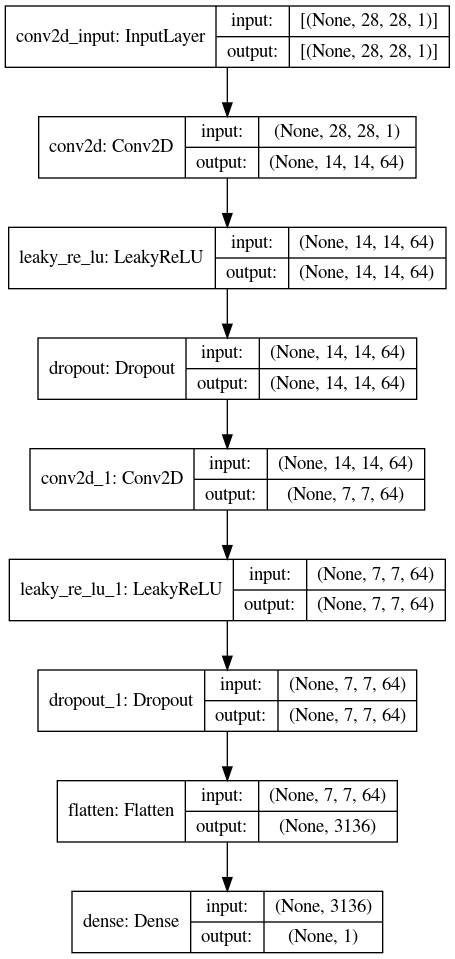

In [5]:
 
# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Leaky Rectified Linear Unit, or Leaky ReLU, is a type of activation function based on a ReLU, but it has a small slope for negative values instead of a flat slope. The slope coefficient is determined before training, i.e. it is not learnt during training. This type of activation function is popular in tasks where we we may suffer from sparse gradients, for example training generative adversarial networks.

In [6]:
# load and prepare mnist training images
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = mnist.load_data()
    # expand to 3d, e.g. add channels dimension
    X = numpy.expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X

In [7]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = numpy.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = numpy.ones((n_samples, 1))
    return X, y

In [8]:
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
    # generate uniform random numbers in [0,1]
    X = numpy.random.rand(28 * 28 * n_samples)
    # reshape into a batch of grayscale images
    X = X.reshape((n_samples, 28, 28, 1))
    # generate 'fake' class labels (0)
    y = numpy.zeros((n_samples, 1))
    return X, y

In [9]:
 
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [10]:
# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

>1 real=59% fake=36%
>2 real=72% fake=57%
>3 real=58% fake=77%
>4 real=60% fake=90%
>5 real=70% fake=98%
>6 real=63% fake=100%
>7 real=64% fake=100%
>8 real=62% fake=99%
>9 real=64% fake=100%
>10 real=61% fake=100%
>11 real=62% fake=100%
>12 real=61% fake=100%
>13 real=65% fake=100%
>14 real=67% fake=100%
>15 real=69% fake=100%
>16 real=66% fake=100%
>17 real=70% fake=100%
>18 real=71% fake=100%
>19 real=73% fake=100%
>20 real=83% fake=100%
>21 real=80% fake=100%
>22 real=91% fake=100%
>23 real=87% fake=100%
>24 real=91% fake=100%
>25 real=95% fake=100%
>26 real=95% fake=100%
>27 real=92% fake=100%
>28 real=95% fake=100%
>29 real=96% fake=100%
>30 real=98% fake=100%
>31 real=99% fake=100%
>32 real=97% fake=100%
>33 real=100% fake=100%
>34 real=99% fake=100%
>35 real=100% fake=100%
>36 real=99% fake=100%
>37 real=99% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=100% fake=100%
>44 real=100% fake

In [11]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 28, 28, 128)      

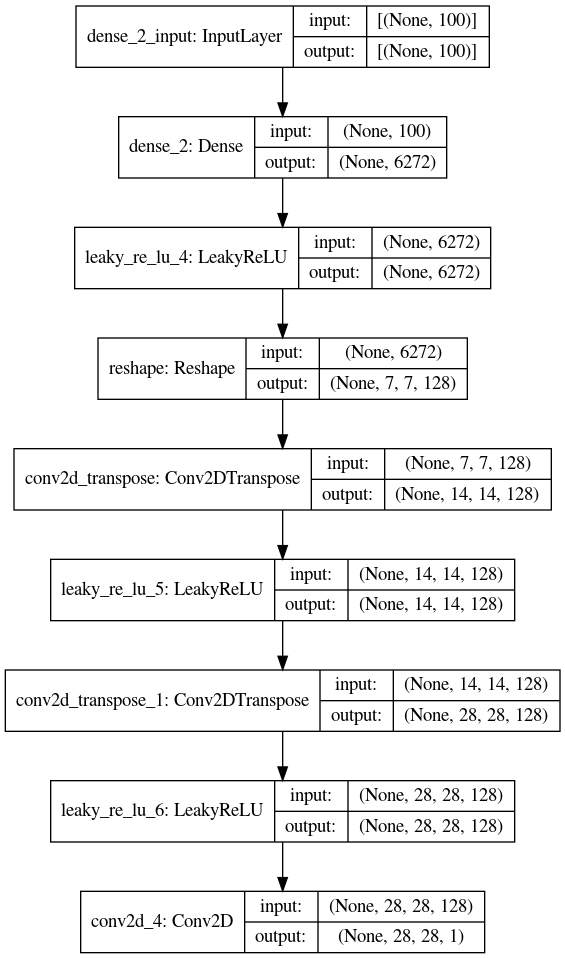

In [12]:
# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = numpy.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [14]:
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = numpy.zeros((n_samples, 1))
    return X, y

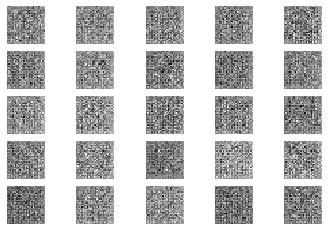

In [15]:
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
    # define subplot
    pyplot.subplot(5, 5, 1 + i)
    # turn off axis labels
    pyplot.axis('off')
    # plot single image
    pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
pyplot.show()

In [16]:

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


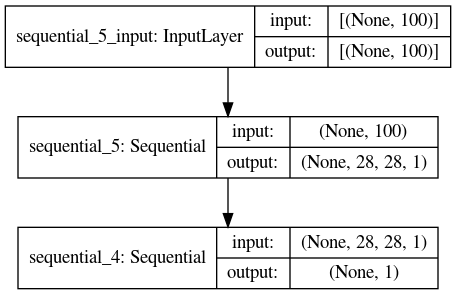

In [17]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [18]:

# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)

In [20]:

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [27]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
    # enumerate batches over the training set
            for j in range(bat_per_epo):
                # get randomly selected 'real' samples
                X_real, y_real = generate_real_samples(dataset, half_batch)
                # generate 'fake' examples
                X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
                # create training set for the discriminator
                X, y = numpy.vstack((X_real, X_fake)), numpy.vstack((y_real, y_fake))
                # update discriminator model weights
                d_loss, _ = d_model.train_on_batch(X, y)
                # prepare points in latent space as input for the generator
                X_gan = generate_latent_points(latent_dim, n_batch)
                # create inverted labels for the fake samples
                y_gan = numpy.ones((n_batch, 1))
                # update the generator via the discriminator's error
                g_loss = gan_model.train_on_batch(X_gan, y_gan)
                # summarize loss on this batch
                print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
            if (i+1) % 10 == 0:
                summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/234, d=0.687, g=0.723
>1, 2/234, d=0.683, g=0.745
>1, 3/234, d=0.673, g=0.770
>1, 4/234, d=0.665, g=0.784
>1, 5/234, d=0.654, g=0.811
>1, 6/234, d=0.647, g=0.830
>1, 7/234, d=0.636, g=0.841
>1, 8/234, d=0.635, g=0.862
>1, 9/234, d=0.630, g=0.865
>1, 10/234, d=0.628, g=0.866
>1, 11/234, d=0.623, g=0.861
>1, 12/234, d=0.628, g=0.837
>1, 13/234, d=0.633, g=0.813
>1, 14/234, d=0.638, g=0.784
>1, 15/234, d=0.643, g=0.759
>1, 16/234, d=0.645, g=0.741
>1, 17/234, d=0.641, g=0.729
>1, 18/234, d=0.639, g=0.718
>1, 19/234, d=0.636, g=0.711
>1, 20/234, d=0.628, g=0.707
>1, 21/234, d=0.621, g=0.704
>1, 22/234, d=0.614, g=0.703
>1, 23/234, d=0.601, g=0.702
>1, 24/234, d=0.594, g=0.701
>1, 25/234, d=0.591, g=0.701
>1, 26/234, d=0.577, g=0.702
>1, 27/234, d=0.567, g=0.701
>1, 28/234, d=0.564, g=0.702
>1, 29/234, d=0.551, g=0.702
>1, 30/234, d=0.550, g=0.702
>1, 31/234, d=0.531, g=0.703
>1, 32/234, d=0.522, g=0.703
>1, 33/234, d=0.506, g=0.704
>1, 34/234, d=0.504, g=0.705
>1, 35/234, d=0.491, g=